In [1]:
#cell 1
!pip install -q "numpy>=2.0,<2.3" "ml-dtypes>=0.5.0" "protobuf>=5.26.1,<7" \
               "tensorflow==2.19.*" "tf-keras==2.19.*" \
               "opencv-python==4.10.0.84" hdf5storage scipy pandas scikit-learn xgboost tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 6.0 MB/s eta 0:00:00


In [2]:
#cell 2
import tensorflow as tf, numpy as np, cv2
import keras as tfkeras
import pandas as pd, scipy
from sklearn.model_selection import GroupShuffleSplit
print("TF:", tf.__version__)
print("NumPy:", np.__version__)
print("tf-keras:", tfkeras.__version__)


TF: 2.19.0
NumPy: 2.0.2
tf-keras: 3.10.0


In [3]:
#cell 2a  (NEW) — device config (safe for CPU/GPU)
import tensorflow as tf
from tensorflow.keras import mixed_precision

if not tf.config.list_physical_devices('GPU'):
    mixed_precision.set_global_policy('float32')
    try:
        tf.config.optimizer.set_jit(False)
    except Exception as e:
        print("XLA disable note:", e)
else:
    mixed_precision.set_global_policy('mixed_float16')
    tf.config.optimizer.set_jit(True)
print("Devices:", tf.config.list_physical_devices())


Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
#cell 3
from google.colab import drive
drive.mount('/content/drive')

ROOT_DIR = "/content"
DRIVE_DIR = "/content/drive/MyDrive"

# Your Figshare zip path in Google Drive
ZIP_PATH = "/content/drive/MyDrive/brain tumor datasets2/1512427.zip"  # <-- edit if needed

RAW_DIR  = f"{ROOT_DIR}/raw_mat_zips"
MAT_DIR  = f"{ROOT_DIR}/mat_files"
IMG_DIR  = f"{ROOT_DIR}/images_by_class"
SPLIT_DIR= f"{ROOT_DIR}/splits"

# NEW: persistent dirs on Drive
MODEL_DIR  = f"{DRIVE_DIR}/brain_tumor_models"
SPLITS_ZIP = f"{DRIVE_DIR}/bt_splits_v1.zip"

import os
for p in [RAW_DIR, MAT_DIR, IMG_DIR, SPLIT_DIR, MODEL_DIR]:
    os.makedirs(p, exist_ok=True)

print("Using ZIP:", ZIP_PATH)
assert os.path.exists(ZIP_PATH), "❌ ZIP_PATH not found — check your Google Drive path."


Mounted at /content/drive
Using ZIP: /content/drive/MyDrive/brain tumor datasets2/1512427.zip


In [5]:
#cell 3a  (NEW) — fast restore of splits if zip exists in Drive
import os, zipfile, shutil

if os.path.exists(SPLITS_ZIP):
    shutil.rmtree(SPLIT_DIR, ignore_errors=True)
    os.makedirs(SPLIT_DIR, exist_ok=True)
    with zipfile.ZipFile(SPLITS_ZIP, 'r') as z:
        z.extractall(SPLIT_DIR)
    print("✅ Restored splits from:", SPLITS_ZIP)
    print("You can SKIP cells 4 → 7 (data conversion and split).")
else:
    print("No saved splits zip found. Run cells 4→7 (first time).")


No saved splits zip found. Run cells 4→7 (first time).


In [6]:
#cell 4
import zipfile, shutil, os

# Extract outer zip
with zipfile.ZipFile(ZIP_PATH, 'r') as z:
    z.extractall(RAW_DIR)

# Extract inner zips
def extract_all_inner_zips(base_dir):
    for root, _, files in os.walk(base_dir):
        for f in files:
            if f.lower().endswith(".zip"):
                zpath = os.path.join(root, f)
                try:
                    with zipfile.ZipFile(zpath, 'r') as z:
                        z.extractall(root)
                except zipfile.BadZipFile:
                    print("Bad zip:", zpath)

extract_all_inner_zips(RAW_DIR)

# Gather .mat files
count = 0
for root, _, files in os.walk(RAW_DIR):
    for f in files:
        if f.lower().endswith(".mat"):
            src = os.path.join(root, f)
            dst = os.path.join(MAT_DIR, f)
            if not os.path.exists(dst):
                shutil.copy2(src, dst)
                count += 1

print("MAT files collected:", count)


MAT files collected: 3065


In [7]:
#cell 5
# --- FINAL robust converter for Figshare brain_tumor_dataset ---
!pip -q install hdf5storage scipy opencv-python pandas

import os, glob, pathlib, shutil
import numpy as np, cv2, pandas as pd, tqdm
import scipy.io as sio
import hdf5storage as h5s

# Reset output images to avoid mixing partial runs
if os.path.exists(IMG_DIR):
    shutil.rmtree(IMG_DIR)
os.makedirs(IMG_DIR, exist_ok=True)

CLASS_MAP = {1: "meningioma", 2: "glioma", 3: "pituitary"}
for cname in CLASS_MAP.values():
    os.makedirs(os.path.join(IMG_DIR, cname), exist_ok=True)

def _squeeze(x):
    if isinstance(x, np.ndarray):
        return np.squeeze(x)
    return x

def _as_plain(x):
    x = _squeeze(x)
    if isinstance(x, np.ndarray) and x.dtype == object and x.size == 1:
        return _as_plain(x.item())
    return x

def get_field(cj, key):
    if isinstance(cj, dict):
        if key in cj: return _as_plain(cj[key])
        if key.encode() in cj: return _as_plain(cj[key.encode()])
        for k in cj.keys():
            k2 = k.decode() if isinstance(k, bytes) else str(k)
            if k2.lower() == key.lower():
                return _as_plain(cj[k])
    if isinstance(cj, (np.void, np.ndarray)) and getattr(cj, "dtype", None) is not None and getattr(cj.dtype, "names", None):
        names = {n.lower(): n for n in cj.dtype.names}
        if key.lower() in names:
            return _as_plain(cj[names[key.lower()]])
        for n in cj.dtype.names:
            n_cmp = n.decode() if isinstance(n, bytes) else n
            if n_cmp.lower() == key.lower():
                return _as_plain(cj[n])
    for attr in (key, key.lower(), key.upper()):
        try:
            return _as_plain(getattr(cj, attr))
        except Exception:
            pass
    if isinstance(cj, np.ndarray) and getattr(cj, "dtype", None) is not None and cj.dtype.names and cj.size >= 1:
        return get_field(cj.flat[0], key)
    raise KeyError(f"Field '{key}' not found in cjdata type={type(cj)}")

def load_cjdata(path):
    try:
        md = sio.loadmat(path, struct_as_record=False, squeeze_me=True)
        if 'cjdata' in md:
            cj = md['cjdata']
            label = get_field(cj, 'label')
            pid   = get_field(cj, 'PID')
            img   = get_field(cj, 'image')
            return label, pid, img
    except NotImplementedError:
        pass
    md = h5s.loadmat(path, simplify_cells=True)
    if 'cjdata' not in md:
        keys = {k.lower(): k for k in md.keys()}
        if 'cjdata' not in keys:
            raise ValueError("No 'cjdata' found")
        cj = md[keys['cjdata']]
    else:
        cj = md['cjdata']
    label = get_field(cj, 'label')
    pid   = get_field(cj, 'PID')
    img   = get_field(cj, 'image')
    return label, pid, img

def to_int_label(x):
    x = _as_plain(x)
    try:
        return int(np.array(x).astype(np.int64).item())
    except Exception:
        return int(str(x))

def to_str_pid(x):
    x = _as_plain(x)
    return str(x)

def fix_image_shape(img):
    img = _as_plain(img)
    img = np.array(img)
    img = np.squeeze(img)
    if img.ndim == 2:
        return img.astype(np.float32)
    if img.ndim == 3:
        if img.shape[-1] in (1, 3):
            return img.astype(np.float32)
        if img.shape[0] in (1, 3):
            return np.moveaxis(img, 0, -1).astype(np.float32)
        img2 = np.squeeze(img)
        if img2.ndim == 2:
            return img2.astype(np.float32)
        return img[..., 0].astype(np.float32)
    img = np.squeeze(img)
    if img.ndim >= 2:
        return img[..., 0].astype(np.float32)
    raise ValueError("Unsupported image dimensionality")

meta_rows, bad_files = [], []
mat_files = sorted(glob.glob(os.path.join(MAT_DIR, "*.mat")))

for m in tqdm.tqdm(mat_files, desc="Converting MAT->PNG"):
    base = pathlib.Path(m).stem.lower()
    if base == "cvind":
        continue
    try:
        label, pid, img = load_cjdata(m)
        label = to_int_label(label)
        pid   = to_str_pid(pid)
        img   = fix_image_shape(img)

        img = img.astype(np.float32)
        mn, mx = float(np.nanmin(img)), float(np.nanmax(img))
        if not np.isfinite(mn) or not np.isfinite(mx):
            raise ValueError("NaNs/Inf in image")
        if mx > mn:
            img8 = ((img - mn) / (mx - mn) * 255.0).clip(0,255).astype(np.uint8)
        else:
            img8 = np.zeros_like(img, dtype=np.uint8)

        if img8.ndim == 2:
            png = cv2.merge([img8, img8, img8])
        elif img8.ndim == 3 and img8.shape[-1] == 3:
            png = img8
        else:
            base2d = img8[..., 0] if img8.ndim == 3 else img8
            png = cv2.merge([base2d, base2d, base2d])

        cname = CLASS_MAP[int(label)]
        out_path = os.path.join(IMG_DIR, cname, f"{pathlib.Path(m).stem}.png")
        cv2.imwrite(out_path, png)

        meta_rows.append({
            "path": out_path,
            "label": cname,
            "label_id": int(label),
            "pid": pid
        })
    except Exception as e:
        bad_files.append((m, repr(e)))

meta = pd.DataFrame(meta_rows)
print(f"Converted: {len(meta)}  |  Bad files: {len(bad_files)}")
if bad_files[:8]:
    print("Example errors:", bad_files[:8])
display(meta.head())


Converting MAT->PNG: 100%|██████████| 3065/3065 [01:11<00:00, 42.63it/s]

Converted: 3064  |  Bad files: 0


,path,label,label_id,pid
0,/content/images_by_class/meningioma/1.png,meningioma,1,100360
1,/content/images_by_class/meningioma/10.png,meningioma,1,101016
2,/content/images_by_class/meningioma/100.png,meningioma,1,107494
3,/content/images_by_class/pituitary/1000.png,pituitary,3,112649
4,/content/images_by_class/pituitary/1001.png,pituitary,3,112649


In [8]:
#cell 6
# 4) Group-aware stratified split by PID (avoid patient leakage)
from sklearn.model_selection import GroupShuffleSplit
from collections import Counter

label_to_id = {c:i for i,c in enumerate(sorted(meta['label'].unique()))}
meta['y'] = meta['label'].map(label_to_id)

def group_split(df, test_size=0.15, val_size=0.15, random_state=42):
    groups = df['pid'].values
    y = df['y'].values
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_val_idx, test_idx = next(gss.split(df, y=y, groups=groups))
    df_train_val = df.iloc[train_val_idx].reset_index(drop=True)
    df_test = df.iloc[test_idx].reset_index(drop=True)

    gss2 = GroupShuffleSplit(n_splits=1, test_size=val_size/(1-test_size), random_state=random_state)
    tr_idx, val_idx = next(gss2.split(df_train_val, y=df_train_val['y'], groups=df_train_val['pid']))
    df_train = df_train_val.iloc[tr_idx].reset_index(drop=True)
    df_val = df_train_val.iloc[val_idx].reset_index(drop=True)
    return df_train, df_val, df_test

train_df, val_df, test_df = group_split(meta, test_size=0.15, val_size=0.15, random_state=123)

print("Train:", len(train_df), Counter(train_df['label']))
print("Val:  ", len(val_df), Counter(val_df['label']))
print("Test: ", len(test_df), Counter(test_df['label']))


Train: 2048 Counter({'glioma': 870, 'pituitary': 671, 'meningioma': 507})
Val:   538 Counter({'glioma': 292, 'pituitary': 138, 'meningioma': 108})
Test:  478 Counter({'glioma': 264, 'pituitary': 121, 'meningioma': 93})


In [9]:
#cell 7
# 5) Materialize directory structure for train/val/test (optional but convenient)
import shutil, os

def materialize_split(split_df, split_name):
    base = os.path.join(SPLIT_DIR, split_name)
    if os.path.exists(base):
        shutil.rmtree(base)
    for c in CLASS_MAP.values():
        os.makedirs(os.path.join(base, c), exist_ok=True)
    for _, r in split_df.iterrows():
        dst = os.path.join(base, r['label'], os.path.basename(r['path']))
        if not os.path.exists(dst):
            shutil.copy2(r['path'], dst)
    return base

train_dir = materialize_split(train_df, "train")
val_dir   = materialize_split(val_df,   "val")
test_dir  = materialize_split(test_df,  "test")
print(train_dir, val_dir, test_dir, sep="\n")

# --- NEW: Save splits zip to Drive for future fast restore ---
SPLITS_ZIP = f"{DRIVE_DIR}/bt_splits_v1.zip"
if not os.path.exists(SPLITS_ZIP):
    tmp_zip = "/content/splits_v1"
    shutil.make_archive(tmp_zip, "zip", SPLIT_DIR)
    shutil.move(tmp_zip + ".zip", SPLITS_ZIP)
    print("✅ Saved splits zip to:", SPLITS_ZIP)
else:
    print("Splits zip already exists:", SPLITS_ZIP)


/content/splits/train
/content/splits/val
/content/splits/test
✅ Saved splits zip to: /content/drive/MyDrive/bt_splits_v1.zip


In [10]:
#cell 8
# 6) TensorFlow datasets + class weights
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 13

train_ds_cat = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    label_mode='categorical', seed=SEED, shuffle=True
)
val_ds_cat = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    label_mode='categorical', seed=SEED, shuffle=False
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds_cat = train_ds_cat.prefetch(AUTOTUNE)
val_ds_cat   = val_ds_cat.prefetch(AUTOTUNE)

# Compute class weights from training split
y_train_ints = train_df['y'].values.astype(int)
classes = np.unique(y_train_ints)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_ints)
class_weights = {int(c): float(w) for c, w in zip(classes, cw)}
print("Class weights:", class_weights)


Found 2048 files belonging to 3 classes.
Found 538 files belonging to 3 classes.
Class weights: {0: 0.7846743295019157, 1: 1.346482577251808, 2: 1.0173869846000994}


In [11]:
#cell 9
# 7) Augmentation & normalization
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.03),
    tf.keras.layers.RandomZoom(0.03),
    tf.keras.layers.RandomTranslation(0.03, 0.03),
], name="aug")

norm_layer = tf.keras.layers.Rescaling(1./255, name="rescale")


In [12]:
#cell 10
# 8) Deeper custom CNN (back-to-back conv blocks + light residuals)
from tensorflow.keras import layers, models, optimizers, regularizers
import tensorflow as tf

def conv_block(x, filters, k=3, pool=True):
    y = layers.Conv2D(filters, k, padding='same', use_bias=False)(x)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)
    y = layers.Conv2D(filters, k, padding='same', use_bias=False)(y)
    y = layers.BatchNormalization()(y)
    if x.shape[-1] != filters:
        x = layers.Conv2D(filters, 1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
    y = layers.Add()([x, y])
    y = layers.ReLU()(y)
    if pool:
        y = layers.MaxPooling2D()(y)
    return y

def build_cnn(input_shape=(224, 224, 3), num_classes=3):
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = norm_layer(x)
    x = conv_block(x, 32)
    x = conv_block(x, 64)
    x = conv_block(x, 128)
    x = conv_block(x, 128, pool=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    return models.Model(inputs, outputs, name="BrainTumorCNN_Custom")


In [13]:
#cell 11
# Rebuild TF datasets with integer labels so class_weight works
import tensorflow as tf, os

IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 13

train_raw = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    label_mode='int', seed=SEED, shuffle=True
)
val_raw = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    label_mode='int', seed=SEED, shuffle=False
)
test_raw = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    label_mode='int', seed=SEED, shuffle=False
)

class_names = val_raw.class_names
print("class_names:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_raw.prefetch(AUTOTUNE)
val_ds   = val_raw.prefetch(AUTOTUNE)
test_ds  = test_raw.prefetch(AUTOTUNE)


Found 2048 files belonging to 3 classes.
Found 538 files belonging to 3 classes.
Found 478 files belonging to 3 classes.
class_names: ['glioma', 'meningioma', 'pituitary']


In [14]:
#cell 12
# 9) Callbacks: EarlyStopping + ReduceLROnPlateau + Checkpoint
ckpt_path = f"{MODEL_DIR}/best_cnn.keras"  # save to Drive
cbs = [
    tf.keras.callbacks.BackupAndRestore(backup_dir=f"{MODEL_DIR}/backup_oldcnn"),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=1)
]


In [15]:
#cell 13
# (final): Train 3 variants with higher LR + aligned class weights (sparse labels)
import tensorflow as tf, os

seeds = [13, 42, 123]
ckpts = []
histories = []

for s in seeds:
    tf.keras.utils.set_random_seed(s)
    m = build_cnn()  # your back-to-back CNN from Cell 10

    m.compile(
        optimizer=tf.keras.optimizers.Adam(3e-4),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    ckpt_path_s = f"{MODEL_DIR}/best_cnn_seed{s}.keras"  # save to Drive
    backup_dir  = f"{MODEL_DIR}/backup_oldcnn_seed{s}"

    cbs_s = [
        tf.keras.callbacks.BackupAndRestore(backup_dir=backup_dir),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
        tf.keras.callbacks.ModelCheckpoint(ckpt_path_s, monitor='val_loss', save_best_only=True, verbose=1),
    ]

    print(f"\n=== Training seed {s} ===")
    h = m.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        class_weight=class_weights,  # from Cell 8
        callbacks=cbs_s,
        verbose=1
    )
    histories.append(h)
    m.save(ckpt_path_s)
    ckpts.append(ckpt_path_s)

ckpts



=== Training seed 13 ===
Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.4961 - loss: 1.1938
Epoch 1: val_loss improved from inf to 1.32162, saving model to /content/drive/MyDrive/brain_tumor_models/best_cnn_seed13.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 95s 297ms/step - accuracy: 0.4971 - loss: 1.1915 - val_accuracy: 0.5428 - val_loss: 1.3216 - learning_rate: 3.0000e-04
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.6568 - loss: 0.8144
Epoch 2: val_loss did not improve from 1.32162
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 279ms/step - accuracy: 0.6569 - loss: 0.8141 - val_accuracy: 0.5428 - val_loss: 1.9034 - learning_rate: 3.0000e-04
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.7046 - loss: 0.7190
Epoch 3: val_loss did not improve from 1.32162
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - accuracy: 0.7045 - loss: 0.7186 - val_accuracy: 0.5428 - val_loss: 3.2105 - learning_rate: 3.0000e-04
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - ac

['/content/drive/MyDrive/brain_tumor_models/best_cnn_seed13.keras',
 '/content/drive/MyDrive/brain_tumor_models/best_cnn_seed42.keras',
 '/content/drive/MyDrive/brain_tumor_models/best_cnn_seed123.keras']

Class order: ['glioma', 'meningioma', 'pituitary']
              precision    recall  f1-score   support

      glioma     0.9197    0.9545    0.9368       264
  meningioma     0.8409    0.7957    0.8177        93
   pituitary     1.0000    0.9587    0.9789       121

    accuracy                         0.9247       478
   macro avg     0.9202    0.9030    0.9111       478
weighted avg     0.9247    0.9247    0.9243       478

Acc/Macro-F1/Weighted-F1: 0.9246861924686193 0.9111284951917477 0.9242833502282539


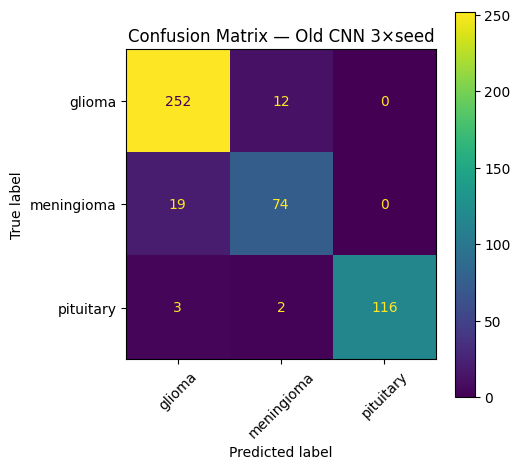

In [16]:
#cell 14
# Evaluate ensemble (average softmax across the 3 saved models) — OLD CNN
import numpy as np, tensorflow as tf, os
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
import matplotlib.pyplot as plt

ckpts = [f"{MODEL_DIR}/best_cnn_seed13.keras",
         f"{MODEL_DIR}/best_cnn_seed42.keras",
         f"{MODEL_DIR}/best_cnn_seed123.keras"]
ckpts = [p for p in ckpts if os.path.exists(p)]
assert len(ckpts)>=1, "No old-CNN checkpoints found in Drive."

models_ens = [tf.keras.models.load_model(p, compile=False) for p in ckpts]
probs_list = [m.predict(test_ds, verbose=0) for m in models_ens]
probs_ens = np.mean(probs_list, axis=0)
y_pred = probs_ens.argmax(1)

y_true = np.concatenate([y.numpy() for _, y in test_ds.unbatch().batch(1024)], axis=0)

print("Class order:", class_names)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
print("Acc/Macro-F1/Weighted-F1:",
      accuracy_score(y_true,y_pred),
      f1_score(y_true,y_pred,average='macro'),
      f1_score(y_true,y_pred,average='weighted'))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, xticks_rotation=45, values_format='d')
plt.title("Confusion Matrix — Old CNN 3×seed")
plt.show()


In [17]:
#cell 15
# sanity check
from collections import Counter
print("Train counts:", Counter(train_df['label']))
print("Val counts:  ", Counter(val_df['label']))
print("Test counts: ", Counter(test_df['label']))


Train counts: Counter({'glioma': 870, 'pituitary': 671, 'meningioma': 507})
Val counts:   Counter({'glioma': 292, 'pituitary': 138, 'meningioma': 108})
Test counts:  Counter({'glioma': 264, 'pituitary': 121, 'meningioma': 93})


In [18]:
#cell 16
import tensorflow as tf, numpy as np

num_classes = len(class_names)
# derive alpha from your training distribution (inverse frequency):
y_train_ints = train_df['y'].values.astype(int)
counts = np.bincount(y_train_ints, minlength=num_classes).astype(np.float32)
alpha = counts.sum()/np.maximum(counts,1.0)
alpha = alpha/alpha.sum()  # normalize to sum=1
alpha = tf.constant(alpha, dtype=tf.float32)

def sparse_categorical_focal_loss(gamma=2.0, alpha_vec=None):
    # y_true: int labels, y_pred: probabilities
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0-1e-7)
        y_true_oh = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
        pt = tf.reduce_sum(y_true_oh * y_pred, axis=-1)
        alpha_w = 1.0
        if alpha_vec is not None:
            class_alpha = tf.reduce_sum(y_true_oh * alpha_vec, axis=-1)
            alpha_w = class_alpha
        focal = -alpha_w * tf.pow(1.0-pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(focal)
    return loss_fn
print("alpha:", alpha.numpy())


alpha: [0.24921815 0.42765248 0.32312936]


In [19]:
#cell 17
# Build balanced training dataset directory (oversampling) -> train_ds_bal
import os, shutil
import tensorflow as tf

def materialize_balanced_train(src_dir=train_dir, classes=class_names):
    tmp = os.path.join(ROOT_DIR, "train_balanced")
    if os.path.exists(tmp):
        shutil.rmtree(tmp)
    os.makedirs(tmp, exist_ok=True)
    # count per class
    counts = {c: len(os.listdir(os.path.join(src_dir, c))) for c in classes}
    max_count = max(counts.values())
    for c in classes:
        os.makedirs(os.path.join(tmp, c), exist_ok=True)
        files = [os.path.join(src_dir, c, f) for f in os.listdir(os.path.join(src_dir, c))]
        reps = (max_count + len(files) - 1) // len(files)
        picks = (files * reps)[:max_count]
        for p in picks:
            shutil.copy2(p, os.path.join(tmp, c, os.path.basename(p)))
    return tmp

BAL_TRAIN_DIR = materialize_balanced_train()
train_ds_bal = tf.keras.preprocessing.image_dataset_from_directory(
    BAL_TRAIN_DIR, image_size=(224,224), batch_size=32,
    label_mode='int', seed=13, shuffle=True
).prefetch(tf.data.AUTOTUNE)
print("Balanced train dir:", BAL_TRAIN_DIR)


Found 2048 files belonging to 3 classes.
Balanced train dir: /content/train_balanced


In [20]:
#cell 18
from tensorflow.keras import layers, models, regularizers

def sep_block(x, filters, pool=True, name=None):
    y = layers.SeparableConv2D(filters, 3, padding='same', use_bias=False, name=name and name+"_sc1")(x)
    y = layers.BatchNormalization()(y); y = layers.ReLU()(y)
    y = layers.SeparableConv2D(filters, 3, padding='same', use_bias=False, name=name and name+"_sc2")(y)
    y = layers.BatchNormalization()(y)
    # residual (project if channels differ)
    if x.shape[-1] != filters:
        x = layers.Conv2D(filters, 1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
    y = layers.Add()([x, y]); y = layers.ReLU()(y)
    if pool: y = layers.MaxPooling2D()(y)
    return y

def build_cnn_sep(input_shape=(224,224,3), num_classes=3):
    inp = layers.Input(input_shape)
    x = data_augmentation(inp)
    x = layers.Rescaling(1./255)(x)

    # wider but efficient blocks
    x = sep_block(x, 48,  name="b1")
    x = sep_block(x, 96,  name="b2")
    x = sep_block(x, 160, name="b3")
    x = sep_block(x, 160, pool=False, name="b4")

    x = layers.GlobalAveragePooling2D(name="feat")(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    return models.Model(inp, out, name="BrainTumorCNN_Separable")


In [21]:
#cell 19
# Train single separable CNN (m2) with focal loss — saved to Drive
from tensorflow.keras.optimizers import AdamW

m2 = build_cnn_sep(input_shape=(224,224,3), num_classes=len(class_names))
m2.compile(optimizer=AdamW(learning_rate=3e-4, weight_decay=1e-4),
           loss=sparse_categorical_focal_loss(gamma=2.0, alpha_vec=alpha),
           metrics=['accuracy'])

ckpt_path_m2 = f"{MODEL_DIR}/best_sep_single.keras"
cbs2 = [
    tf.keras.callbacks.BackupAndRestore(backup_dir=f"{MODEL_DIR}/backup_sep_single"),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(ckpt_path_m2, monitor='val_loss', save_best_only=True, verbose=1)
]
h2 = m2.fit(
    train_ds_bal,
    validation_data=val_ds,
    epochs=50,
    callbacks=cbs2,
    verbose=1
)
m2.save(ckpt_path_m2)
print("Saved single separable CNN to:", ckpt_path_m2)


Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.4354 - loss: 0.2784
Epoch 1: val_loss improved from inf to 0.16324, saving model to /content/drive/MyDrive/brain_tumor_models/best_sep_single.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 49s 281ms/step - accuracy: 0.4362 - loss: 0.2775 - val_accuracy: 0.2565 - val_loss: 0.1632 - learning_rate: 3.0000e-04
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.5600 - loss: 0.1514
Epoch 2: val_loss improved from 0.16324 to 0.16295, saving model to /content/drive/MyDrive/brain_tumor_models/best_sep_single.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 324ms/step - accuracy: 0.5603 - loss: 0.1513 - val_accuracy: 0.2565 - val_loss: 0.1630 - learning_rate: 3.0000e-04
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.6443 - loss: 0.1283
Epoch 3: val_loss improved from 0.16295 to 0.16014, saving model to /content/drive/MyDrive/brain_tumor_models/best_sep_single.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 225ms/step - accuracy: 0.64

Class order: ['glioma', 'meningioma', 'pituitary']
              precision    recall  f1-score   support

      glioma     0.9917    0.9091    0.9486       264
  meningioma     0.7652    0.9462    0.8462        93
   pituitary     0.9752    0.9752    0.9752       121

    accuracy                         0.9331       478
   macro avg     0.9107    0.9435    0.9233       478
weighted avg     0.9435    0.9331    0.9354       478

CNN — Accuracy / Macro-F1 / Weighted-F1: 0.9330543933054394 0.9233256861715359 0.9354123228054464


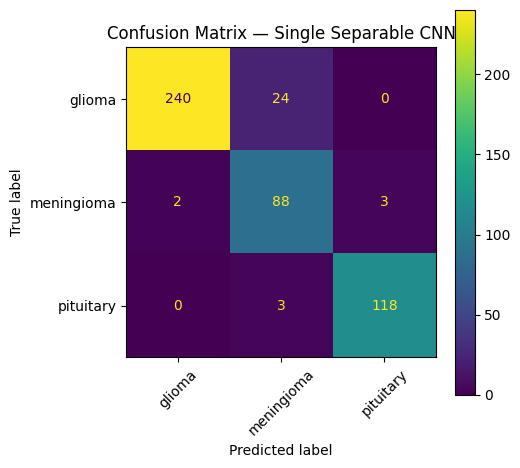

In [22]:
#cell 20
# Evaluate single separable CNN (m2)
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

m2_loaded = tf.keras.models.load_model(ckpt_path_m2, compile=False)
probs_cnn = m2_loaded.predict(test_ds, verbose=0)
y_pred_cnn = probs_cnn.argmax(1)
y_true = np.concatenate([y.numpy() for _, y in test_ds.unbatch().batch(2048)], axis=0)

print("Class order:", class_names)
print(classification_report(y_true, y_pred_cnn, target_names=class_names, digits=4))
print("CNN — Accuracy / Macro-F1 / Weighted-F1:",
      accuracy_score(y_true,y_pred_cnn),
      f1_score(y_true,y_pred_cnn,average='macro'),
      f1_score(y_true,y_pred_cnn,average='weighted'))

cm = confusion_matrix(y_true, y_pred_cnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, xticks_rotation=45, values_format='d')
plt.title("Confusion Matrix — Single Separable CNN")
plt.show()


In [23]:
#cell 21
# Build meta-features for stacking (CNN softmax -> meta features)
import numpy as np, tensorflow as tf

def probs_and_labels(ds, model):
    probs = model.predict(ds, verbose=0)
    y_true = np.concatenate([y.numpy() for _, y in ds.unbatch().batch(4096)], axis=0)
    return probs, y_true

def add_meta_features(probs):
    max_p  = probs.max(axis=1, keepdims=True)
    top2   = np.partition(probs, -2, axis=1)[:, -2]
    margin = (max_p[:,0] - top2).reshape(-1,1)
    eps=1e-9
    ent = -np.sum(probs * np.log(probs+eps), axis=1, keepdims=True)
    return np.concatenate([probs, max_p, margin, ent], axis=1)

probs_val, y_val   = probs_and_labels(val_ds,  m2_loaded)
probs_test, y_test = probs_and_labels(test_ds, m2_loaded)

X_meta_val  = add_meta_features(probs_val)
X_meta_test = add_meta_features(probs_test)
print("X_meta_val:", X_meta_val.shape, "X_meta_test:", X_meta_test.shape)


X_meta_val: (538, 6) X_meta_test: (478, 6)


Class order: ['glioma', 'meningioma', 'pituitary']
              precision    recall  f1-score   support

      glioma     0.8901    0.9205    0.9050       264
  meningioma     0.6630    0.6559    0.6595        93
   pituitary     0.9558    0.8926    0.9231       121

    accuracy                         0.8619       478
   macro avg     0.8363    0.8230    0.8292       478
weighted avg     0.8625    0.8619    0.8618       478

Stacked — Accuracy / Macro-F1 / Weighted-F1: 0.8619246861924686 0.8291881051657587 0.8618188529784799


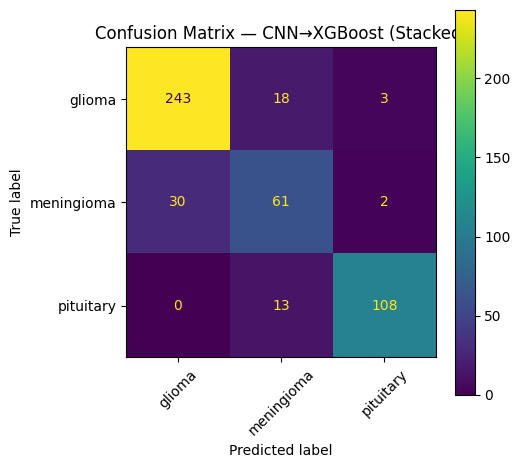

In [24]:
#cell 22
# Train XGBoost on CNN probabilities (stacking) and evaluate
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
import matplotlib.pyplot as plt

xgb_stack = XGBClassifier(
    n_estimators=400, max_depth=4, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
    objective='multi:softprob', num_class=len(class_names), tree_method='hist'
)
xgb_stack.fit(X_meta_val, y_val)

y_pred_stack = xgb_stack.predict(X_meta_test)
print("Class order:", class_names)
print(classification_report(y_test, y_pred_stack, target_names=class_names, digits=4))

print("Stacked — Accuracy / Macro-F1 / Weighted-F1:",
      accuracy_score(y_test,y_pred_stack),
      f1_score(y_test,y_pred_stack,average='macro'),
      f1_score(y_test,y_pred_stack,average='weighted'))

cm = confusion_matrix(y_test, y_pred_stack)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, xticks_rotation=45, values_format='d')
plt.title("Confusion Matrix — CNN→XGBoost (Stacked)")
plt.show()


In [25]:
#cell 23
# alpha sanity
print(alpha.numpy(), alpha.shape)


[0.24921815 0.42765248 0.32312936] (3,)


In [26]:
#cell 24
# 3-seed training for separable CNN — saved to Drive + resume-safe
import tensorflow as tf, os
from tensorflow.keras.optimizers import AdamW

seeds = [13, 42, 123]
ckpts_sep = []
histories_sep = []

for s in seeds:
    tf.keras.utils.set_random_seed(s)
    m = build_cnn_sep(input_shape=(224,224,3), num_classes=len(class_names))
    m.compile(
        optimizer=AdamW(learning_rate=3e-4, weight_decay=1e-4),
        loss=sparse_categorical_focal_loss(gamma=2.0, alpha_vec=alpha),
        metrics=['accuracy']
    )

    ckpt_path_s = f"{MODEL_DIR}/best_sep_seed{s}.keras"
    backup_dir  = f"{MODEL_DIR}/backup_sep_seed{s}"

    cbs_s = [
        tf.keras.callbacks.BackupAndRestore(backup_dir=backup_dir),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
        tf.keras.callbacks.ModelCheckpoint(ckpt_path_s, monitor='val_loss', save_best_only=True, verbose=1),
    ]

    print(f"\n=== Training separable CNN seed {s} ===")
    h = m.fit(
        train_ds_bal,
        validation_data=val_ds,
        epochs=60,
        callbacks=cbs_s,
        verbose=1
    )
    histories_sep.append(h)
    m.save(ckpt_path_s)
    ckpts_sep.append(ckpt_path_s)

ckpts_sep



=== Training separable CNN seed 13 ===
Epoch 1/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.4721 - loss: 0.2602
Epoch 1: val_loss improved from inf to 0.16250, saving model to /content/drive/MyDrive/brain_tumor_models/best_sep_seed13.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 267ms/step - accuracy: 0.4729 - loss: 0.2595 - val_accuracy: 0.2007 - val_loss: 0.1625 - learning_rate: 3.0000e-04
Epoch 2/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.6002 - loss: 0.1450
Epoch 2: val_loss did not improve from 0.16250
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 232ms/step - accuracy: 0.6002 - loss: 0.1449 - val_accuracy: 0.2007 - val_loss: 0.1634 - learning_rate: 3.0000e-04
Epoch 3/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6323 - loss: 0.1280
Epoch 3: val_loss did not improve from 0.16250
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - accuracy: 0.6325 - loss: 0.1279 - val_accuracy: 0.2007 - val_loss: 0.1657 - learning_rate: 3.0000e-04
Epoch 4/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1

['/content/drive/MyDrive/brain_tumor_models/best_sep_seed13.keras',
 '/content/drive/MyDrive/brain_tumor_models/best_sep_seed42.keras',
 '/content/drive/MyDrive/brain_tumor_models/best_sep_seed123.keras']

Class order: ['glioma', 'meningioma', 'pituitary']
              precision    recall  f1-score   support

      glioma     0.9798    0.9205    0.9492       264
  meningioma     0.7928    0.9462    0.8627        93
   pituitary     1.0000    0.9835    0.9917       121

    accuracy                         0.9414       478
   macro avg     0.9242    0.9501    0.9345       478
weighted avg     0.9486    0.9414    0.9431       478

Ensemble — Accuracy / Macro-F1 / Weighted-F1: 0.9414225941422594 0.9345435049019608 0.9431395623102798


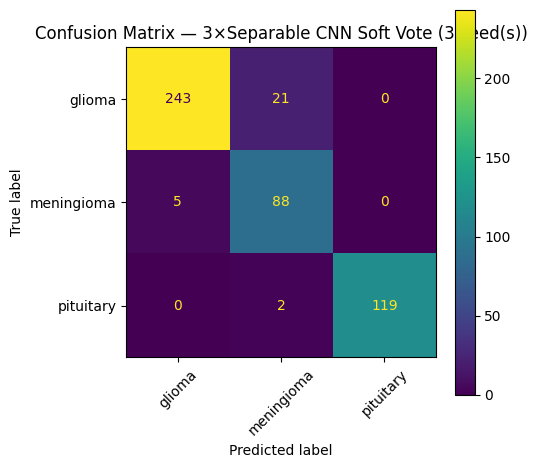

In [27]:
  #cell 25
# Final ensemble evaluation (soft vote over 3 saved separable CNNs)
import numpy as np, tensorflow as tf, os
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
import matplotlib.pyplot as plt

ckpts = [
    f"{MODEL_DIR}/best_sep_seed13.keras",
    f"{MODEL_DIR}/best_sep_seed42.keras",
    f"{MODEL_DIR}/best_sep_seed123.keras",
]
ckpts = [p for p in ckpts if os.path.exists(p)]
assert len(ckpts)>=1, "No separable-CNN checkpoints found — train at least one seed in Cell 24."

models_ens = [tf.keras.models.load_model(p, compile=False) for p in ckpts]
probs_list = [m.predict(test_ds, verbose=0) for m in models_ens]
probs_ens = np.mean(probs_list, axis=0)
y_pred = probs_ens.argmax(1)
y_true = np.concatenate([y.numpy() for _, y in test_ds.unbatch().batch(2048)], axis=0)

print("Class order:", class_names)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
print("Ensemble — Accuracy / Macro-F1 / Weighted-F1:",
      accuracy_score(y_true,y_pred),
      f1_score(y_true,y_pred,average='macro'),
      f1_score(y_true,y_pred,average='weighted'))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, xticks_rotation=45, values_format='d')
plt.title(f"Confusion Matrix — 3×Separable CNN Soft Vote ({len(ckpts)} seed(s))")
plt.show()



=== Ensemble (3×CNN) ===


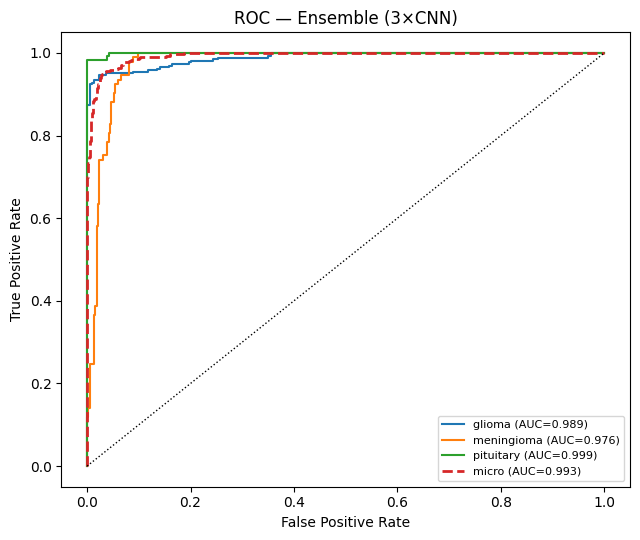

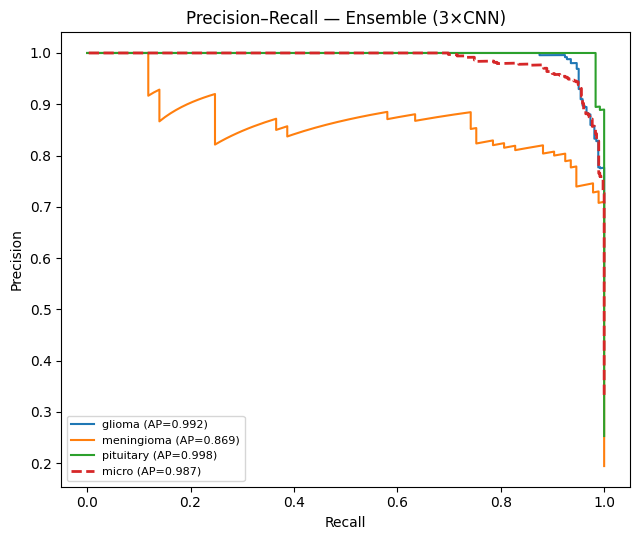

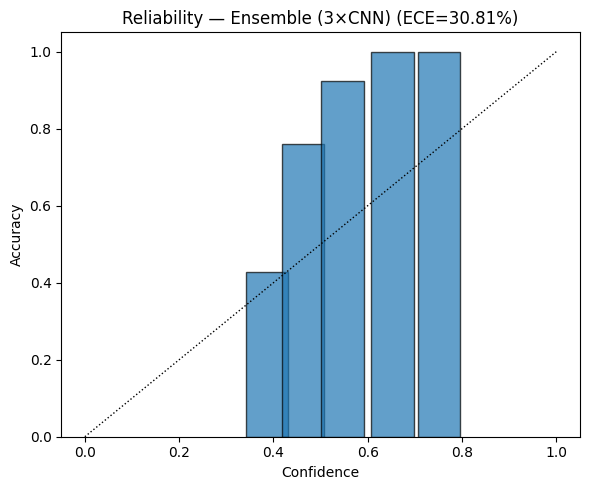

Saved: {'roc': '/content/drive/MyDrive/brain_tumor_models/figs/roc_ensemble_(3×cnn).png', 'pr': '/content/drive/MyDrive/brain_tumor_models/figs/pr_ensemble_(3×cnn).png', 'cal': '/content/drive/MyDrive/brain_tumor_models/figs/calibration_ensemble_(3×cnn).png'}

=== Single CNN ===


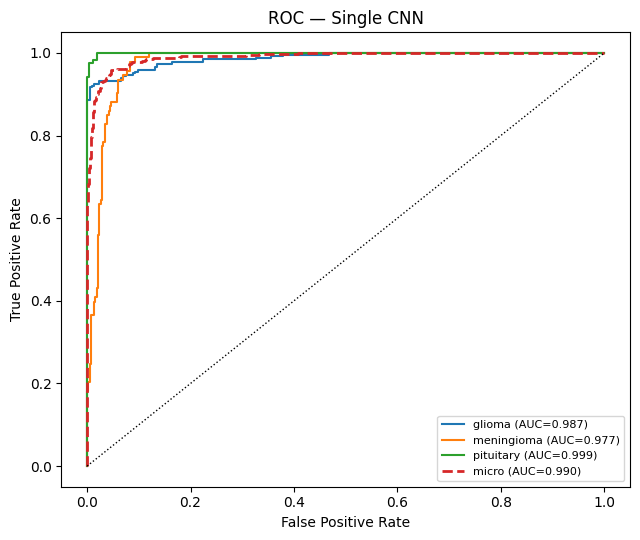

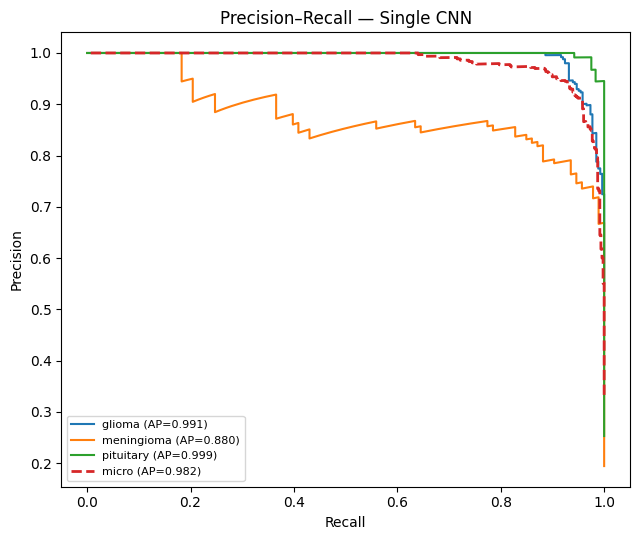

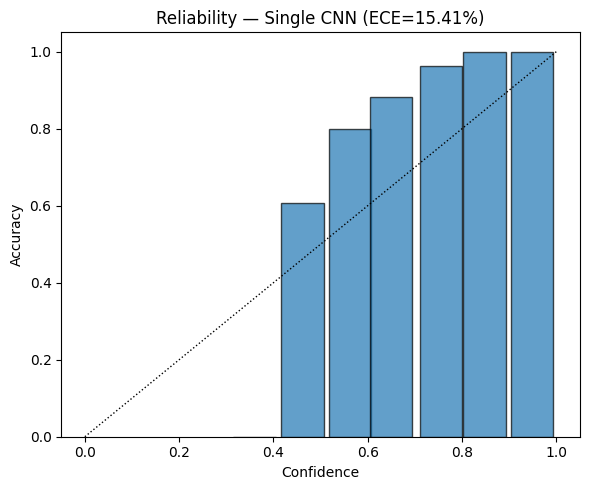

Saved: {'roc': '/content/drive/MyDrive/brain_tumor_models/figs/roc_single_cnn.png', 'pr': '/content/drive/MyDrive/brain_tumor_models/figs/pr_single_cnn.png', 'cal': '/content/drive/MyDrive/brain_tumor_models/figs/calibration_single_cnn.png'}

=== CNN→XGBoost (stacked) ===


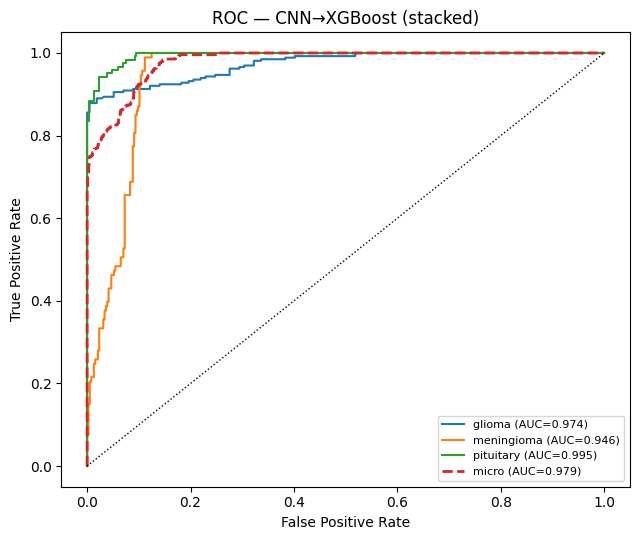

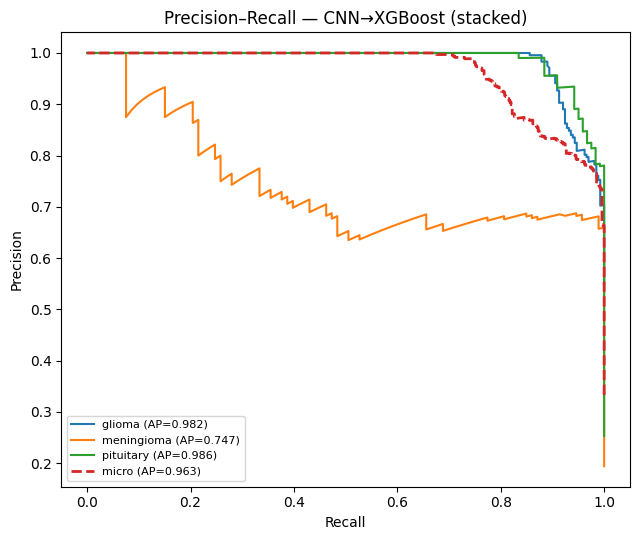

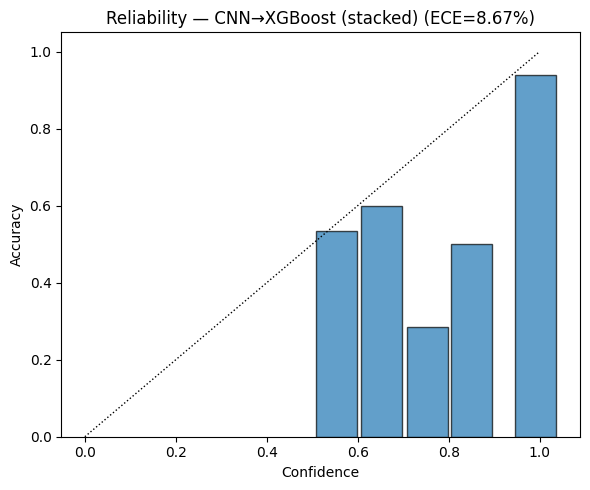

Saved: {'roc': '/content/drive/MyDrive/brain_tumor_models/figs/roc_cnn→xgboost_(stacked).png', 'pr': '/content/drive/MyDrive/brain_tumor_models/figs/pr_cnn→xgboost_(stacked).png', 'cal': '/content/drive/MyDrive/brain_tumor_models/figs/calibration_cnn→xgboost_(stacked).png'}


,Accuracy,F1_macro,F1_weighted,ROC-AUC_macro,ROC-AUC_micro,AP_macro,AP_micro,ECE_%
Model,,,,,,,,
Ensemble (3×CNN),0.9414,0.9345,0.9431,0.9881,0.9930,0.9532,0.9868,30.8087
Single CNN,0.9331,0.9233,0.9354,0.9878,0.9899,0.9567,0.9823,15.4064
CNN→XGBoost (stacked),0.8619,0.8292,0.8618,0.9714,0.9795,0.9051,0.9631,8.6747



Saved metrics table to: /content/drive/MyDrive/brain_tumor_models/figs/final_metrics_table.csv
Figures saved under: /content/drive/MyDrive/brain_tumor_models/figs


In [28]:
#cell 26
# Final plots + metrics for your report: ROC, PR, Calibration + summary table
import os, numpy as np, matplotlib.pyplot as plt, pandas as pd
from sklearn.metrics import (
    roc_curve, auc, roc_auc_score,
    precision_recall_curve, average_precision_score,
    classification_report, accuracy_score, f1_score
)
from sklearn.preprocessing import label_binarize

# Where to save figures/tables in Drive
FIGS_DIR = f"{MODEL_DIR}/figs"
os.makedirs(FIGS_DIR, exist_ok=True)

# === Helper: compute scores + plots for ONE model (probs/y_true) ===
def multiclass_curves_and_scores(y_true, probs, class_names, tag="Ensemble"):
    n_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    # ---- ROC (OvR): per-class, micro, macro ----
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Micro
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Macro (mean of per-class AUCs)
    roc_auc["macro"] = np.mean([roc_auc[i] for i in range(n_classes)])

    # Plot ROC
    plt.figure(figsize=(6.5,5.5))
    for i, name in enumerate(class_names):
        plt.plot(fpr[i], tpr[i], lw=1.5, label=f"{name} (AUC={roc_auc[i]:.3f})")
    plt.plot(fpr["micro"], tpr["micro"], lw=2.0, linestyle="--", label=f"micro (AUC={roc_auc['micro']:.3f})")
    plt.plot([0,1],[0,1], "k:", lw=1)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"ROC — {tag}")
    plt.legend(loc="lower right", fontsize=8)
    roc_path = os.path.join(FIGS_DIR, f"roc_{tag.replace(' ','_').lower()}.png")
    plt.tight_layout(); plt.savefig(roc_path, dpi=180); plt.show()

    # ---- Precision–Recall: per-class, micro, macro AP ----
    prec, rec, ap = {}, {}, {}
    for i in range(n_classes):
        prec[i], rec[i], _ = precision_recall_curve(y_true_bin[:, i], probs[:, i])
        ap[i] = average_precision_score(y_true_bin[:, i], probs[:, i])

    # Micro PR
    prec["micro"], rec["micro"], _ = precision_recall_curve(y_true_bin.ravel(), probs.ravel())
    ap["micro"] = average_precision_score(y_true_bin, probs, average="micro")
    ap["macro"] = average_precision_score(y_true_bin, probs, average="macro")

    # Plot PR
    plt.figure(figsize=(6.5,5.5))
    for i, name in enumerate(class_names):
        plt.plot(rec[i], prec[i], lw=1.5, label=f"{name} (AP={ap[i]:.3f})")
    plt.plot(rec["micro"], prec["micro"], lw=2.0, linestyle="--", label=f"micro (AP={ap['micro']:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"Precision–Recall — {tag}")
    plt.legend(loc="lower left", fontsize=8)
    pr_path = os.path.join(FIGS_DIR, f"pr_{tag.replace(' ','_').lower()}.png")
    plt.tight_layout(); plt.savefig(pr_path, dpi=180); plt.show()

    # ---- Calibration (reliability) with ECE on max-prob ----
    pred = probs.argmax(1)
    conf = probs.max(1)
    correct = (pred == y_true).astype(float)
    bins = np.linspace(0.0, 1.0, 11)  # 10 bins
    bin_ids = np.digitize(conf, bins) - 1
    bin_acc, bin_conf, bin_frac = [], [], []
    for b in range(len(bins)-1):
        m = bin_ids == b
        if m.sum() == 0:
            continue
        bin_acc.append(correct[m].mean())
        bin_conf.append(conf[m].mean())
        bin_frac.append(m.mean())
    # Expected Calibration Error (ECE)
    ece = np.sum(np.abs(np.array(bin_acc) - np.array(bin_conf)) * np.array(bin_frac)) * 100.0

    # Plot reliability
    plt.figure(figsize=(6,5))
    plt.plot([0,1],[0,1],"k:", lw=1)
    plt.bar(bin_conf, bin_acc, width=0.09, alpha=0.7, edgecolor="k")
    plt.xlabel("Confidence"); plt.ylabel("Accuracy")
    plt.title(f"Reliability — {tag} (ECE={ece:.2f}%)")
    cal_path = os.path.join(FIGS_DIR, f"calibration_{tag.replace(' ','_').lower()}.png")
    plt.tight_layout(); plt.savefig(cal_path, dpi=180); plt.show()

    # ---- Scalar summary
    acc = accuracy_score(y_true, pred)
    f1m = f1_score(y_true, pred, average="macro")
    f1w = f1_score(y_true, pred, average="weighted")
    auc_macro = roc_auc_score(y_true, probs, multi_class="ovr", average="macro")
    auc_micro = roc_auc_score(y_true, probs, multi_class="ovr", average="micro")
    ap_macro  = average_precision_score(y_true_bin, probs, average="macro")
    ap_micro  = average_precision_score(y_true_bin, probs, average="micro")

    row = {
        "Model": tag,
        "Accuracy": acc,
        "F1_macro": f1m,
        "F1_weighted": f1w,
        "ROC-AUC_macro": auc_macro,
        "ROC-AUC_micro": auc_micro,
        "AP_macro": ap_macro,
        "AP_micro": ap_micro,
        "ECE_%": ece
    }
    return row, {"roc": roc_path, "pr": pr_path, "cal": cal_path}

# === Build a comparison set (only adds what you already have in memory) ===
MODELS = {"Ensemble (3×CNN)": probs_ens}
if "probs_cnn" in globals():  # from Cell 20 (single best)
    MODELS["Single CNN"] = probs_cnn
# If you trained stacking (Cell 22) and want to include it:
try:
    if "xgb_stack" in globals() and "X_meta_test" in globals():
        probs_stack = xgb_stack.predict_proba(X_meta_test)
        MODELS["CNN→XGBoost (stacked)"] = probs_stack
except Exception as e:
    print("Stacking probs not added:", e)

# === Generate plots + table ===
rows = []
for name, P in MODELS.items():
    print(f"\n=== {name} ===")
    r, paths = multiclass_curves_and_scores(y_true, P, class_names, tag=name)
    rows.append(r)
    print("Saved:", paths)

df = pd.DataFrame(rows).set_index("Model").round(4)
display(df)

# Save table to Drive
table_path = os.path.join(FIGS_DIR, "final_metrics_table.csv")
df.to_csv(table_path, index=True)
print("\nSaved metrics table to:", table_path)
print("Figures saved under:", FIGS_DIR)



=== Ensemble (3×CNN) ===


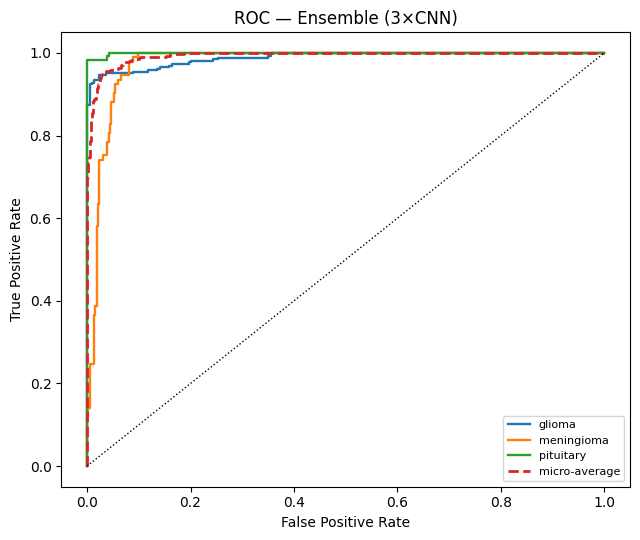

Saved ROC: /content/drive/MyDrive/brain_tumor_models/figs/roc_ensemble_(3×cnn).png

=== Single CNN ===


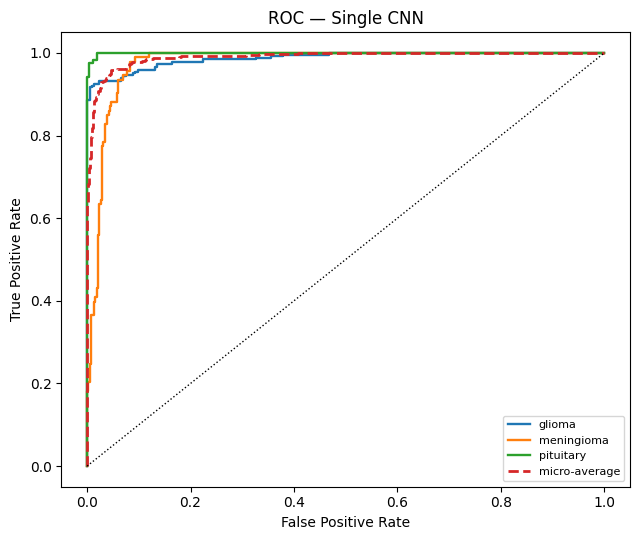

Saved ROC: /content/drive/MyDrive/brain_tumor_models/figs/roc_single_cnn.png

=== CNN→XGBoost (stacked) ===


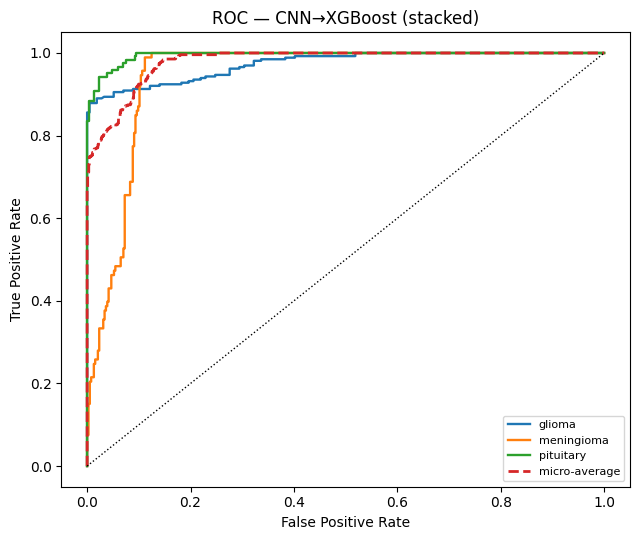

Saved ROC: /content/drive/MyDrive/brain_tumor_models/figs/roc_cnn→xgboost_(stacked).png


,Accuracy,F1_macro,F1_weighted
Model,,,
Ensemble (3×CNN),0.9414,0.9345,0.9431
Single CNN,0.9331,0.9233,0.9354
CNN→XGBoost (stacked),0.8619,0.8292,0.8618



Saved metrics table to: /content/drive/MyDrive/brain_tumor_models/figs/final_metrics_table.csv
Figures saved under: /content/drive/MyDrive/brain_tumor_models/figs


In [35]:
#cell 26a — ROC-only plots + final table (Accuracy, F1-macro, F1-weighted)
import os, numpy as np, matplotlib.pyplot as plt, pandas as pd
from sklearn.metrics import roc_curve, accuracy_score, f1_score
from sklearn.preprocessing import label_binarize

# Where to save figures/tables in Drive
FIGS_DIR = f"{MODEL_DIR}/figs"
os.makedirs(FIGS_DIR, exist_ok=True)

def plot_multiclass_roc_only(y_true, probs, class_names, tag="Ensemble"):
    """Plot per-class and micro-average ROC curves (no AUC numbers)."""
    n_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    # Per-class ROC
    plt.figure(figsize=(6.5,5.5))
    for i, name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs[:, i])
        plt.plot(fpr, tpr, lw=1.7, label=name)

    # Micro-average ROC (still just a ROC curve; no AUC shown)
    fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), probs.ravel())
    plt.plot(fpr_micro, tpr_micro, lw=2.0, linestyle="--", label="micro-average")

    plt.plot([0,1],[0,1], "k:", lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC — {tag}")
    plt.legend(loc="lower right", fontsize=8)
    out = os.path.join(FIGS_DIR, f"roc_{tag.replace(' ','_').lower()}.png")
    plt.tight_layout(); plt.savefig(out, dpi=180); plt.show()
    return out

def model_row(y_true, probs, tag):
    pred = probs.argmax(1)
    return {
        "Model": tag,
        "Accuracy": accuracy_score(y_true, pred),
        "F1_macro": f1_score(y_true, pred, average="macro"),
        "F1_weighted": f1_score(y_true, pred, average="weighted"),
    }

# === Build a comparison set (only adds what you already have in memory) ===
MODELS = {"Ensemble (3×CNN)": probs_ens}
if "probs_cnn" in globals():  # from Cell 20 (single best)
    MODELS["Single CNN"] = probs_cnn
# If you trained stacking (Cell 22) and want to include it:
try:
    if "xgb_stack" in globals() and "X_meta_test" in globals():
        probs_stack = xgb_stack.predict_proba(X_meta_test)
        MODELS["CNN→XGBoost (stacked)"] = probs_stack
except Exception as e:
    print("Stacking probs not added:", e)

# === Generate ROC plots + final table ===
rows = []
for name, P in MODELS.items():
    print(f"\n=== {name} ===")
    roc_path = plot_multiclass_roc_only(y_true, P, class_names, tag=name)
    print("Saved ROC:", roc_path)
    rows.append(model_row(y_true, P, name))

df = pd.DataFrame(rows).set_index("Model").round(4)
display(df)

# Save table to Drive
table_path = os.path.join(FIGS_DIR, "final_metrics_table.csv")
df.to_csv(table_path, index=True)
print("\nSaved metrics table to:", table_path)
print("Figures saved under:", FIGS_DIR)


In [29]:
#cell 27a
# Final ensemble evaluation — setup & load models (compile=False)
import os, numpy as np, tensorflow as tf

ckpts = [
    f"{MODEL_DIR}/best_sep_seed13.keras",
    f"{MODEL_DIR}/best_sep_seed42.keras",
    f"{MODEL_DIR}/best_sep_seed123.keras",
]
print("Looking for:", ckpts)
ckpts = [p for p in ckpts if os.path.exists(p)]
print("Using:", ckpts)
assert len(ckpts) >= 1, "No separable-CNN checkpoints found — train at least one seed in Cell 24."

models_ens = [tf.keras.models.load_model(p, compile=False) for p in ckpts]


Looking for: ['/content/drive/MyDrive/brain_tumor_models/best_sep_seed13.keras', '/content/drive/MyDrive/brain_tumor_models/best_sep_seed42.keras', '/content/drive/MyDrive/brain_tumor_models/best_sep_seed123.keras']
Using: ['/content/drive/MyDrive/brain_tumor_models/best_sep_seed13.keras', '/content/drive/MyDrive/brain_tumor_models/best_sep_seed42.keras', '/content/drive/MyDrive/brain_tumor_models/best_sep_seed123.keras']


In [30]:
#cell 27b
# Predict on test set and soft-vote (average) the probabilities
probs_list = [m.predict(test_ds, verbose=0) for m in models_ens]
probs_ens = np.mean(probs_list, axis=0)
y_pred = probs_ens.argmax(1)

# True labels (int) from test_ds
y_true = np.concatenate([y.numpy() for _, y in test_ds.unbatch().batch(2048)], axis=0)
print("probs_ens shape:", probs_ens.shape, "| #test samples:", len(y_true))

# Optional: persist for later plots/tables
np.save(f"{MODEL_DIR}/probs_ens.npy", probs_ens)
np.save(f"{MODEL_DIR}/y_true.npy", y_true)
print("Saved to:", f"{MODEL_DIR}/probs_ens.npy", "and", f"{MODEL_DIR}/y_true.npy")


probs_ens shape: (478, 3) | #test samples: 478
Saved to: /content/drive/MyDrive/brain_tumor_models/probs_ens.npy and /content/drive/MyDrive/brain_tumor_models/y_true.npy


In [31]:
#cell 27c
# Metrics: classification report + summary numbers
from sklearn.metrics import classification_report, accuracy_score, f1_score

print("Class order:", class_names)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

acc = accuracy_score(y_true, y_pred)
f1m = f1_score(y_true, y_pred, average='macro')
f1w = f1_score(y_true, y_pred, average='weighted')
print(f"Ensemble — Accuracy / Macro-F1 / Weighted-F1: {acc:.4f} {f1m:.4f} {f1w:.4f}")


Class order: ['glioma', 'meningioma', 'pituitary']
              precision    recall  f1-score   support

      glioma     0.9798    0.9205    0.9492       264
  meningioma     0.7928    0.9462    0.8627        93
   pituitary     1.0000    0.9835    0.9917       121

    accuracy                         0.9414       478
   macro avg     0.9242    0.9501    0.9345       478
weighted avg     0.9486    0.9414    0.9431       478

Ensemble — Accuracy / Macro-F1 / Weighted-F1: 0.9414 0.9345 0.9431


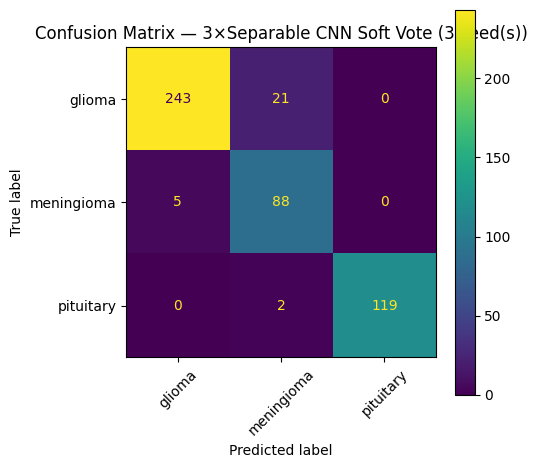

In [32]:
#cell 27d
# Confusion matrix plot
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, xticks_rotation=45, values_format='d')
plt.title(f"Confusion Matrix — 3×Separable CNN Soft Vote ({len(models_ens)} seed(s))")
plt.show()


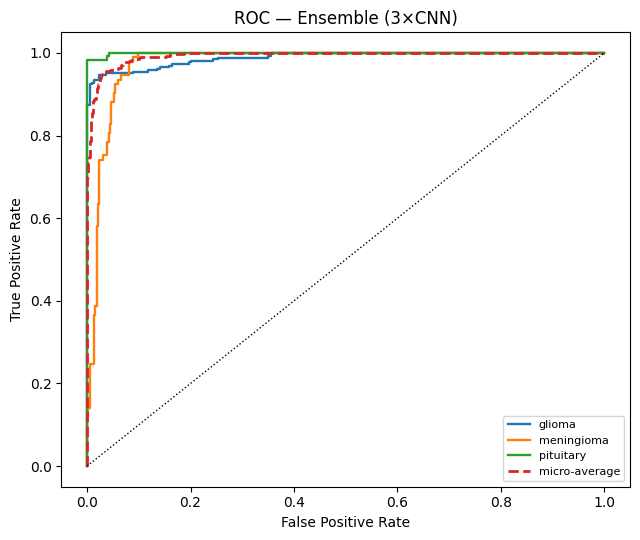

Saved ROC to: /content/drive/MyDrive/brain_tumor_models/figs/roc_ensemble_(3×cnn).png


In [33]:
#cell 26-extra (ROC only)
import os, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve

FIGS_DIR = f"{MODEL_DIR}/figs"
os.makedirs(FIGS_DIR, exist_ok=True)

def plot_roc_only(y_true, probs, class_names, tag="Ensemble"):
    n_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    # Per-class ROC (OvR)
    plt.figure(figsize=(6.5,5.5))
    for i, name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs[:, i])
        plt.plot(fpr, tpr, lw=1.7, label=name)

    # Optional: micro-average ROC (still ROC; no AUC shown)
    fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), probs.ravel())
    plt.plot(fpr_micro, tpr_micro, lw=2.0, linestyle="--", label="micro-average")

    plt.plot([0,1],[0,1], "k:", lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC — {tag}")
    plt.legend(loc="lower right", fontsize=8)
    out = os.path.join(FIGS_DIR, f"roc_{tag.replace(' ','_').lower()}.png")
    plt.tight_layout(); plt.savefig(out, dpi=180); plt.show()
    print("Saved ROC to:", out)

# Plot ROC for the ensemble probs saved in 25b
plot_roc_only(y_true, probs_ens, class_names, tag="Ensemble (3×CNN)")


Chose best by val macro-F1: {'Single': 0.7756751020309155, 'Ensemble': 0.8143220202275335} → Ensemble
Upload a single image (PNG/JPG).


Saving 1841.png to 1841.png
Using image: 1841.png



Model used: Ensemble (3×)
Prediction: glioma  (confidence 0.723)
  glioma      : 0.7225
  meningioma  : 0.1549
  pituitary   : 0.1226


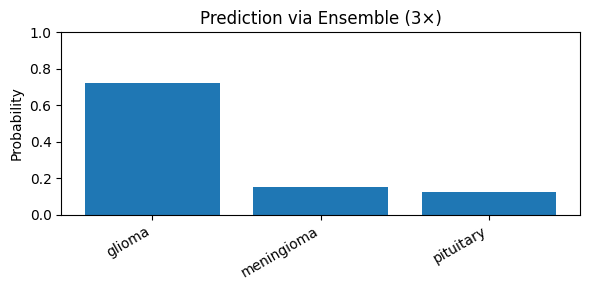

In [34]:
#cell 28 — Single image demo (auto-uses best model)
import os, numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from google.colab import files
from sklearn.metrics import f1_score
from sklearn.preprocessing import label_binarize

# --------- config / paths ----------
ENSEMBLE_CKPTS = [
    f"{MODEL_DIR}/best_sep_seed13.keras",
    f"{MODEL_DIR}/best_sep_seed42.keras",
    f"{MODEL_DIR}/best_sep_seed123.keras",
]
SINGLE_BEST = f"{MODEL_DIR}/best_sep_single.keras"
BEST_CHOICE_FILE = f"{MODEL_DIR}/best_choice.npy"   # will store: "Ensemble" or "Single"

# --------- helpers ----------
def load_models(paths):
    paths = [p for p in paths if os.path.exists(p)]
    return [tf.keras.models.load_model(p, compile=False) for p in paths]

def preprocess_image(path, img_size=None):
    raw = tf.io.read_file(path)
    img = tf.io.decode_image(raw, channels=3, expand_animations=False)
    if img_size is None:  # detect from single-best if present, else default 224
        try:
            m = tf.keras.models.load_model(SINGLE_BEST, compile=False)
            h,w = m.input_shape[1], m.input_shape[2]
            img_size = (h,w)
        except:
            img_size = (224,224)
    img = tf.image.resize(img, img_size, method="bilinear")
    img = tf.cast(img, tf.float32)  # model has its own Rescaling layer
    return img[None, ...]           # [1,H,W,3]

def predict_one(img_tensor, model, tta=True):
    if not tta:
        return model.predict(img_tensor, verbose=0)[0]
    # simple TTA: original + horizontal flip
    p1 = model.predict(img_tensor, verbose=0)[0]
    p2 = model.predict(tf.image.flip_left_right(img_tensor), verbose=0)[0]
    return (p1 + p2) / 2.0

def choose_best_model_by_val(models_ens):
    # If we already saved a choice, use it
    if os.path.exists(BEST_CHOICE_FILE):
        try:
            tag = str(np.load(BEST_CHOICE_FILE, allow_pickle=True).ravel()[0])
            if tag in ("Ensemble","Single"):
                return tag
        except:
            pass

    # Compute validation macro-F1 for Ensemble vs Single (no test leakage)
    # Build y_val ints
    y_val_int = np.concatenate([y.numpy() for _, y in val_ds.unbatch().batch(4096)], axis=0)

    scores = {}

    # Single CNN
    if os.path.exists(SINGLE_BEST):
        m_single = tf.keras.models.load_model(SINGLE_BEST, compile=False)
        probs_single = m_single.predict(val_ds, verbose=0)
        scores["Single"] = f1_score(y_val_int, probs_single.argmax(1), average='macro')

    # Ensemble (if any model present)
    if len(models_ens) > 0:
        probs_ens_val = np.mean([m.predict(val_ds, verbose=0) for m in models_ens], axis=0)
        scores["Ensemble"] = f1_score(y_val_int, probs_ens_val.argmax(1), average='macro')

    assert len(scores)>0, "No model found in Drive. Train at least one model."
    best_tag = max(scores.items(), key=lambda kv: kv[1])[0]
    np.save(BEST_CHOICE_FILE, np.array([best_tag], dtype=object))
    print("Chose best by val macro-F1:", scores, "→", best_tag)
    return best_tag

def barplot_probs(probs, class_names, title="Class probabilities"):
    order = np.argsort(-probs)
    plt.figure(figsize=(6,3))
    plt.bar(range(len(class_names)), probs[order])
    plt.xticks(range(len(class_names)), [class_names[i] for i in order], rotation=30, ha='right')
    plt.ylabel("Probability")
    plt.ylim(0,1)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# --------- load models & pick best ----------
ens_paths = [p for p in ENSEMBLE_CKPTS if os.path.exists(p)]
models_ens = load_models(ens_paths) if len(ens_paths)>0 else []
use_tag = choose_best_model_by_val(models_ens)

# --------- upload image ----------
print("Upload a single image (PNG/JPG).")
up = files.upload()
assert len(up)>0, "No file uploaded."
img_path = list(up.keys())[0]
print("Using image:", img_path)

# --------- predict ----------
img_tensor = preprocess_image(img_path)  # size auto-detected from model if possible
if use_tag == "Ensemble" and len(models_ens)>0:
    probs = np.mean([predict_one(img_tensor, m, tta=True) for m in models_ens], axis=0)
    used_name = f"Ensemble ({len(models_ens)}×)"
else:
    assert os.path.exists(SINGLE_BEST), "Single best model not found in Drive."
    m_single = tf.keras.models.load_model(SINGLE_BEST, compile=False)
    probs = predict_one(img_tensor, m_single, tta=True)
    used_name = "Single CNN"

pred_idx = int(np.argmax(probs))
pred_name = class_names[pred_idx]
conf = float(probs[pred_idx])

print(f"\nModel used: {used_name}")
print(f"Prediction: {pred_name}  (confidence {conf:.3f})")
for i, name in enumerate(class_names):
    print(f"  {name:12s}: {probs[i]:.4f}")

# --------- quick probability bar chart ----------
barplot_probs(probs, class_names, title=f"Prediction via {used_name}")


In [39]:
# (Optional) One-cell health check
import os, glob, json, time, tensorflow as tf

print("Drive mounted:", os.path.exists("/content/drive/MyDrive"))
print("TF:", tf.__version__)
print("MODEL_DIR:", MODEL_DIR)
print("SPLITS_ZIP exists?", os.path.exists(SPLITS_ZIP))

def count_split(base):
    import os, glob
    if not os.path.isdir(base): return {}
    return {c: len(glob.glob(os.path.join(base,c,"*")))
            for c in sorted(os.listdir(base)) if os.path.isdir(os.path.join(base,c))}

for s in ["train","val","test"]:
    print(f"{s:>5}:", count_split(os.path.join(SPLIT_DIR, s)))

ens_ckpts = [f"{MODEL_DIR}/best_sep_seed{s}.keras" for s in [13,42,123]]
ens_ckpts = [p for p in ens_ckpts if os.path.exists(p)]
single_ckpt = f"{MODEL_DIR}/best_sep_single.keras"
print("Ensemble ckpts:", ens_ckpts)
print("Single ckpt:", os.path.exists(single_ckpt))

# Save a tiny manifest
manifest = {
    "tf": tf.__version__,
    "splits_zip_exists": os.path.exists(SPLITS_ZIP),
    "ensemble_ckpts": ens_ckpts,
    "single_ckpt_exists": os.path.exists(single_ckpt),
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
}
with open(f"{MODEL_DIR}/_manifest.json", "w") as f: json.dump(manifest, f, indent=2)
print("Saved:", f"{MODEL_DIR}/_manifest.json")


Drive mounted: True
TF: 2.19.0
MODEL_DIR: /content/drive/MyDrive/brain_tumor_models
SPLITS_ZIP exists? True
train: {'glioma': 870, 'meningioma': 507, 'pituitary': 671}
  val: {'glioma': 292, 'meningioma': 108, 'pituitary': 138}
 test: {'glioma': 264, 'meningioma': 93, 'pituitary': 121}
Ensemble ckpts: ['/content/drive/MyDrive/brain_tumor_models/best_sep_seed13.keras', '/content/drive/MyDrive/brain_tumor_models/best_sep_seed42.keras', '/content/drive/MyDrive/brain_tumor_models/best_sep_seed123.keras']
Single ckpt: True
Saved: /content/drive/MyDrive/brain_tumor_models/_manifest.json
